In [1]:
import silq
silq.initialize("EWJN")

qc.show_subprocess_widget()
%matplotlib nbagg

Initializing imports


<IPython.core.display.Javascript object>

Initializing functions
Initializing instruments
Initializing parameters
Initializing data
Initializing analysis
Initializing plotting
Initialization complete


# Single measurements

In [99]:
# Determine empty, load, read fidelities
ELR_parameter.setup(samples=400)
%time fidelities = ELR_parameter()
pulsemaster.stop()
print('Empty: {:.2f}, Load: {:.2f}, Read: {:.2f}'.format(*fidelities))

Wall time: 15.5 s
Empty: 0.56, Load: 0.96, Read: 0.88


In [106]:
T1_parameter.setup(samples=1000)
T1_parameter(5)
%time up_proportion, = T1_parameter()
print('Up proportion: {:.2f}'.format(up_proportion))

T1_parameter.setup(samples=200)
T1_parameter(3000)
%time up_proportion, = T1_parameter()
print('Up proportion: {:.2f}'.format(up_proportion))

pulsemaster.stop()

Wall time: 1min 10s
Up proportion: 0.47
One peak found instead of two, lowering threshold
One peak found instead of two, lowering threshold
One peak found instead of two, lowering threshold
One peak found instead of two, lowering threshold
Wall time: 10min 6s
Up proportion: 0.00


# DC sweep

### TGAC vs DF_DS

In [5]:
TGAC_vals = list(np.linspace(1.65,1.95, 30))
DF_DS_vals = list(np.linspace(2.54,2.63,40))

In [3]:
DC_parameter.setup()
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(DC_parameter
                          ).run(name='DC_sweep',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-20/#031_DC_sweep_10-59-30'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | SIM900_TGAC_set | TGAC         | (3,)
   Setpoint | DF_DS_set       | DF_DS        | (3, 40)
   Measured | DC_voltage      | DC_voltage   | (3, 40)
started at 2016-09-20 10:59:32


<IPython.core.display.Javascript object>


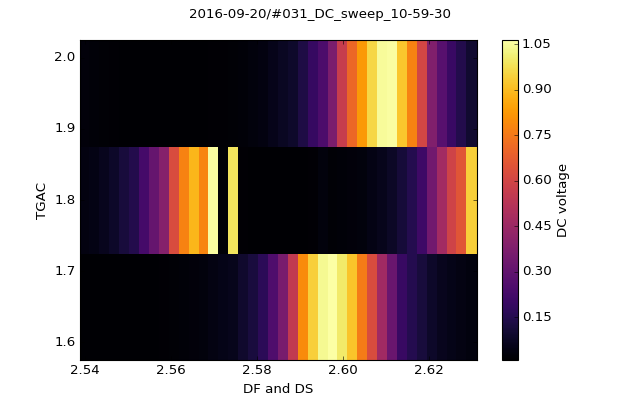

In [4]:
plot = qc.MatPlot()
plot.add(data.DC_voltage)
# plotQ = qc.QtPlot()
# plotQ.add(data.DC_voltage)

# ELRLR sequence

In [37]:
ELRLR_parameter.stages['read']['duration'] = 40

In [38]:
TGAC_vals = list(np.round(np.linspace(1.8368,1.842,6),3))
DF_DS_vals = list(np.round(np.linspace(2.569,2.573,5),3))

In [39]:
ELRLR_parameter.setup(samples=500)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(ELRLR_parameter
                          ).run(name='ELRLR_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-20/#035_ELRLR_calibration_13-28-33'
   <Type>   | <array_id>      | <array.name>   | <array.shape>
   Setpoint | SIM900_TGAC_set | TGAC           | (6,)
   Setpoint | DF_DS_set       | DF_DS          | (6, 5)
   Measured | fidelity_empty  | fidelity_empty | (6, 5)
   Measured | fidelity_load   | fidelity_load  | (6, 5)
   Measured | fidelity_read   | fidelity_read  | (6, 5)
   Measured | up_proportion   | up_proportion  | (6, 5)
   Measured | dark_counts     | dark_counts    | (6, 5)
   Measured | contrast        | contrast       | (6, 5)
started at 2016-09-20 13:28:34


In [12]:
plotQ = qc.QtPlot()
plotQ.add(data.contrast)

plotQ = qc.QtPlot()
plotQ.add(data.dark_counts)

plotQ = qc.QtPlot()
plotQ.add(data.fidelity_load)

plotQ = qc.QtPlot()
plotQ.add(data.fidelity_empty)

c:\users\lab.blug12meas\documents\silq\qcodes\qcodes\plots\pyqtgraph.py:325: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '
c:\users\lab.blug12meas\documents\silq\qcodes\qcodes\plots\pyqtgraph.py:325: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '
c:\users\lab.blug12meas\documents\silq\qcodes\qcodes\plots\pyqtgraph.py:325: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '
c:\users\lab.blug12meas\documents\silq\qcodes\qcodes\plots\pyqtgraph.py:325: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '


<IPython.core.display.Javascript object>


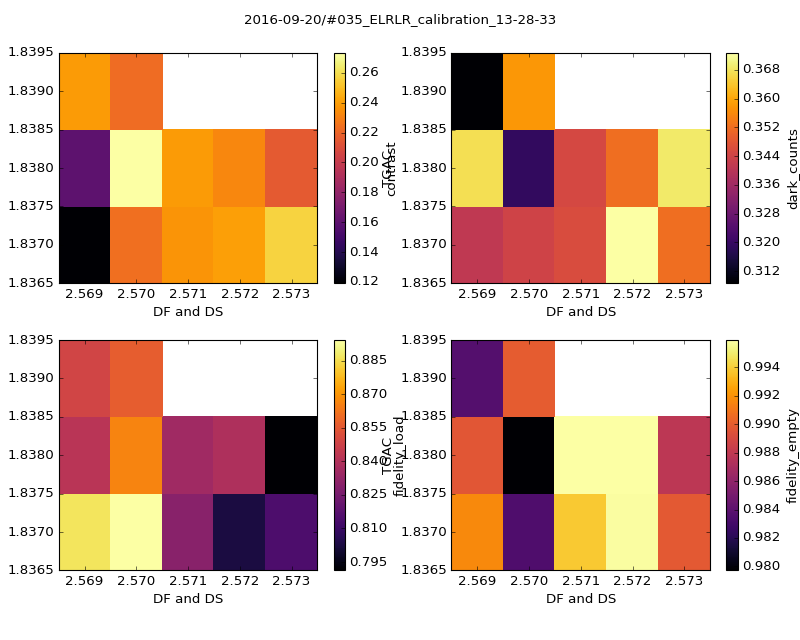

In [40]:
plot = qc.MatPlot(subplots=(2,2), figsize=(10,8))
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
plot.add(data.fidelity_load, subplot=3, nticks=6)
plot.add(data.fidelity_empty, subplot=4, nticks=6)
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [29]:
TGAC(1.838)
DF_DS(2.572)

In [30]:
ELRLR_parameter.setup(samples=400, print=True)
ELRLR_parameter();

fidelity_empty: 0.992
fidelity_load: 0.874
fidelity_read: 0.679
up_proportion: 0.518
dark_counts: 0.322
contrast: 0.197


# Read level sweep

In [56]:
variable_read_parameter.setup(samples=100)
data = qc.Loop(variable_read_parameter[-1.5:2.5:0.04]
                     ).each(variable_read_parameter
                           ).run(name='variable_read',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-19/#021_variable_read_15-41-07'
   <Type>   | <array_id>                | <array.name>          | <array.shape>
   Setpoint | variable_read_voltage_set | variable_read_voltage | (100,)
   Measured | index0                    | index0                | (100, 8992)
   Measured | Channel_A_signal          | Channel_A_signal      | (100, 8992)
   Measured | Channel_C_signal          | Channel_C_signal      | (100, 8992)
started at 2016-09-19 15:41:18


In [42]:
plotQ = qc.QtPlot()
plotQ.add(data.Channel_A_signal)

plotQ = qc.QtPlot()
plotQ.add(data.Channel_C_signal)

# T1 measurement

In [57]:
ELRLR_parameter.stages['read']['duration'] = 20

# Prepare measurements: Determine threshold voltage
ELR_parameter.setup(samples=300, return_traces=True)
_, _, _, _, _,traces, traces_AWG = ELR_parameter()
pulsemaster.stop()
_, _, threshold_voltage = analysis.find_high_low(traces)
assert threshold_voltage is not None, "Couldn't find accurate threshold"
print('Threshold voltage found at {:.2f} V'.format(threshold_voltage))

Threshold voltage found at 0.43 V


In [58]:
# Calculate T1 durations (shuffled)
T1_wait_times = list(np.logspace(1,4,num=20,base=10))
np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [1128.8378916846884, 1623.776739188721, 545.55947811685144, 784.75997035146065, 127.42749857031335, 29.763514416313178, 10.0, 183.29807108324357, 10000.0, 379.26901907322497, 3359.8182862837812, 88.586679041008225, 2335.7214690901214, 20.691380811147901, 61.584821106602639, 14.384498882876629, 263.66508987303581, 4832.9302385717519, 6951.9279617756056, 42.813323987193932]


DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-14/#033_T1_single_sweep_16-33-44'
   <Type>   | <array_id>        | <array.name>      | <array.shape>
   Setpoint | T1_wait_time_set  | T1_wait_time      | (5,)
   Measured | up_proportion     | up_proportion     | (5,)
   Measured | num_traces_loaded | num_traces_loaded | (5,)
started at 2016-09-14 16:33:45


<IPython.core.display.Javascript object>


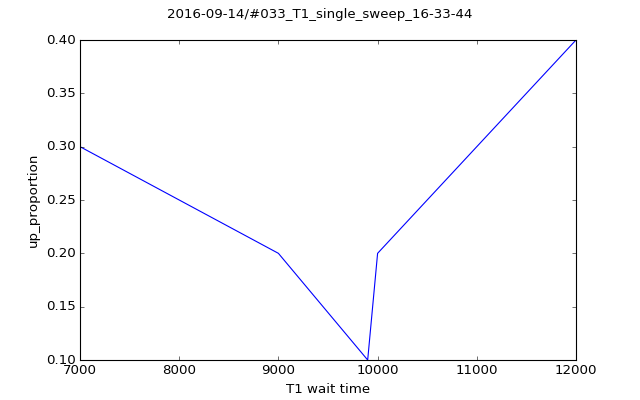

In [38]:
# Single T1 sweep
T1_parameter.setup(threshold_voltage=threshold_voltage, samples=10)

data = qc.Loop(T1_parameter[T1_wait_times]
                     ).each(T1_parameter
                           ).run(name='T1_single_sweep')

plotQ = qc.MatPlot()
plotQ.add(data.up_proportion)

In [59]:
# Continuous T1 sweep
setup_ELRLR = partial(ELRLR_parameter.setup, samples=400, data_manager=data_manager_raw)
setup_T1 = partial(T1_parameter.setup, threshold_voltage=threshold_voltage, samples=150, data_manager=data_manager_raw)
setup_ELRLR()
setup_T1()
data = qc.Loop(dummy_param[0:30:1]
              ).each(qc.Task(setup_ELRLR),
                     ELRLR_parameter,
                     qc.Task(setup_T1),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-19/#022_T1_data_15-52-22'
   <Type>   | <array_id>          | <array.name>      | <array.shape>
   Setpoint | dummy_set           | dummy             | (30,)
   Measured | fidelity_empty      | fidelity_empty    | (30,)
   Measured | fidelity_load       | fidelity_load     | (30,)
   Measured | fidelity_read       | fidelity_read     | (30,)
   Measured | up_proportion_1_3   | up_proportion     | (30,)
   Measured | dark_counts         | dark_counts       | (30,)
   Measured | contrast            | contrast          | (30,)
   Setpoint | T1_wait_time_set    | T1_wait_time      | (30, 20)
   Measured | up_proportion_3_0_0 | up_proportion     | (30, 20)
   Measured | num_traces_loaded   | num_traces_loaded | (30, 20)
started at 2016-09-19 15:52:23
